# CS736 Medical Image Computing
## SuperPixel Image Segmentation using Graph Cuts and SLIC Algorithm
Authors: </br>
Mridul Agarwal (210050100) </br>
Shantanu Welling (210010076)

### Importing Libraries

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import math
from collections import deque
from operator import itemgetter
from networkx.algorithms.flow.utils import build_residual_network
import time

### Defining Constants

In [36]:
SLICO = 101 # SLICO Algorithm Code
sigma1= 0.1 #Standard deviation in neighbour edge weights Gaussian model
lambda1=0.9 #Multiplicative factor for Neighbour weights
regionSize = 20 #Number of pixels in a SuperPixel

### Defining Classes for SuperPixel Nodes and Graph

In [37]:
class SuperPixelNode():
    
    def __init__(self):
        self.label = None
        self.pixels = []
        self.centroid = ()
        self.CIELabHist = None
        self.meanCIELab = None
        self.type = 'na'
        

In [38]:
class BK:
    
    def __init__(self, G, s, t, capacity='capacity', residual=None, value_only=False, cutoff=None):
        self.G = G
        self.s = s
        self.t = t
        self.capacity = capacity
        self.residual = residual
        self.value_only = value_only
        self.cutoff = cutoff
        self.BKImplementation()
        self.R.graph['algorithm'] = 'boykov_kolmogorov'
    
    def getResidual (self):
        return self.R
    
    def BKImplementation (self):
        if self.s not in self.G:
            raise nx.NetworkXError(f'Source node {s} not in graph')
        elif self.t not in self.G:
            raise nx.NetworkXError(f'Sink node {t} not in graph')
        elif self.s == self.t:
            raise nx.NetworkXError(f'Source and sink node are the same')
        if self.residual is None:
            self.R = build_residual_network(self.G, self.capacity)
        else:
            self.R = self.residual
        for u in self.R:
            for e in self.R[u].values():
                e['flow'] = 0
        self.INFTY = self.R.graph['inf']
        if self.cutoff is None:
            self.cutoff = self.INFTY
        self.successor = self.R.succ
        self.predecessor = self.R.pred
        self.source_tree = {self.s: None}
        self.target_tree = {self.t: None}
        self.active = deque([self.s, self.t])
        self.orphans = deque()
        flow_value = 0
        self.time = 1
        self.timestamp = {self.s: self.time, self.t: self.time}
        self.dist = {self.s: 0, self.t: 0}
        while flow_value < self.cutoff:
            u, v = self.grow()
            if u is None:
                break
            self.time += 1
            flow_value += self.augment(u, v)
            self.adopt()
        if flow_value * 2 > self.INFTY:
            raise nx.NetworkXUnbounded('INFTY capacity path, flow unbounded above.')

        self.R.graph['trees'] = (self.source_tree, self.target_tree)
        self.R.graph['flow_value'] = flow_value
        
    def grow (self):
        while self.active:
            u = self.active[0]
            if u in self.source_tree:
                this_tree = self.source_tree
                other_tree = self.target_tree
                neighbors = self.successor
            else:
                this_tree = self.target_tree
                other_tree = self.source_tree
                neighbors = self.predecessor
            for v, attr in neighbors[u].items():
                if attr['capacity'] - attr['flow'] > 0:
                    if v not in this_tree:
                        if v in other_tree:
                            return (u, v) if this_tree is self.source_tree else (v, u)
                        this_tree[v] = u
                        self.dist[v] = self.dist[u] + 1
                        self.timestamp[v] = self.timestamp[u]
                        self.active.append(v)
                    elif v in this_tree and self.isCloser(u, v):
                        this_tree[v] = u
                        self.dist[v] = self.dist[u] + 1
                        self.timestamp[v] = self.timestamp[u]
            _ = self.active.popleft()
        return None, None
    
    def augment (self, u,v):
        attr = self.successor[u][v]
        flow = min(self.INFTY, attr['capacity'] - attr['flow'])
        path = [u]
        w = u
        while w != self.s:
            n = w
            w = self.source_tree[n]
            attr = self.predecessor[n][w]
            flow = min(flow, attr['capacity'] - attr['flow'])
            path.append(w)
        path.reverse()
        path.append(v)
        w = v
        while w != self.t:
            n = w
            w = self.target_tree[n]
            attr = self.successor[n][w]
            flow = min(flow, attr['capacity'] - attr['flow'])
            path.append(w)
        it = iter(path)
        u = next(it)
        these_orphans = []
        for v in it:
            self.successor[u][v]['flow'] += flow
            self.successor[v][u]['flow'] -= flow
            if self.successor[u][v]['flow'] == self.successor[u][v]['capacity']:
                if v in self.source_tree:
                    self.source_tree[v] = None
                    these_orphans.append(v)
                if u in self.target_tree:
                    self.target_tree[u] = None
                    these_orphans.append(u)
            u = v
        self.orphans.extend(sorted(these_orphans, key=self.dist.get))
        return flow
    
    def adopt (self):
        while self.orphans:
            u = self.orphans.popleft()
            if u in self.source_tree:
                tree = self.source_tree
                neighbors = self.predecessor
            else:
                tree = self.target_tree
                neighbors = self.successor
            nbrs = ((n, attr, self.dist[n]) for n, attr in neighbors[u].items()
                    if n in tree)
            for v, attr, d in sorted(nbrs, key=itemgetter(2)):
                if attr['capacity'] - attr['flow'] > 0:
                    if self.hasValidRoot(v, tree):
                        tree[u] = v
                        self.dist[u] = self.dist[v] + 1
                        self.timestamp[u] = self.time
                        break
            else:
                nbrs = ((n, attr, self.dist[n]) for n, attr in neighbors[u].items()
                        if n in tree)
                for v, attr, d in sorted(nbrs, key=itemgetter(2)):
                    if attr['capacity'] - attr['flow'] > 0:
                        if v not in self.active:
                            self.active.append(v)
                    if tree[v] == u:
                        tree[v] = None
                        self.orphans.appendleft(v)
                if u in self.active:
                    self.active.remove(u)
                del tree[u]
    
    def hasValidRoot (self, n, tree):
        path = []
        v = n
        while v is not None:
            path.append(v)
            if v == self.s or v == self.t:
                base_dist = 0
                break
            elif self.timestamp[v] == self.time:
                base_dist = self.dist[v]
                break
            v = tree[v]
        else:
            return False
        length = len(path)
        for i, u in enumerate(path, 1):
            self.dist[u] = base_dist + length - i
            self.timestamp[u] = self.time
        return True
    
    def isCloser (self, u,v):
        return self.timestamp[v] <= self.timestamp[u] and self.dist[v] > self.dist[u] + 1
    
#Boykov Kolmogorov Algorithm for MinCut referred from https://networkx.org/documentation/stable/_modules/networkx/algorithms/flow/boykovkolmogorov.html
#Time complexity of O(mn^2|C|) where graph has m edges, n vertices, C is the sum of all capacities

In [39]:
class SuperPixelGraph():
    
    def __init__(self):
        self.noOfBins = [32,32,32]
        self.rangeOfL = [0,256]
        self.rangeOfa = [0,256]
        self.rangeOfb = [0,256]

    def dist_2D(self,p0,p1):
        return math.sqrt((p0[0]-p1[0])**2+(p0[1]-p1[1])**2) 
        
    def SuperPixelSLICgen(self, I, regionSize):
        spSLIC = cv2.ximgproc.createSuperpixelSLIC(I, algorithm = SLICO, region_size = regionSize, ruler = 10.0)
        spSLIC.iterate(num_iterations = 4)
        return spSLIC

    def drawSPMask(self, I, SP):
        I1 = np.zeros(I.shape)
        I1 = np.copy(I)
        mask = SP.getLabelContourMask()
        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if mask[i][j] == -1 or mask[i][j] == 255:
                    I1[i][j] = [128,128,128]
        return I1

    def drawCentroids(self, I, list_SP):
        for node in list_SP:
            i,j = node.centroid
            I[i][j] = 128
        return I
    
    def graph_gen(self, list_SP, obj_hist, background_hist):
        G=nx.Graph()
        s=SuperPixelNode()
        t=SuperPixelNode()
        s.label='s'
        t.label='t'
        obj_hist_sum=int(obj_hist.sum())
        background_hist_sum=int(background_hist.sum())
        for pixel1 in list_SP:
            K=0
            radius=math.sqrt(len(pixel1.pixels)/math.pi)
            for pixel2 in list_SP:
                if pixel1!=pixel2:
                    if self.dist_2D(pixel1.centroid,pixel2.centroid)<=2.5*radius:
                        nbr_edge_wt=math.exp(-(cv2.compareHist(pixel1.CIELabHist, pixel2.CIELabHist,3)**2/(2*(sigma1**2))))*(1/self.dist_2D(pixel1.centroid,pixel2.centroid))
                        G.add_edge(pixel1,pixel2,sim=nbr_edge_wt)
                        K+=nbr_edge_wt
            if(pixel1.type=='na'):
                l1,a1,b1=[int(x) for x in pixel1.meanCIELab]
                li=int(l1//((self.rangeOfL[1]-self.rangeOfL[0])/self.noOfBins[0]))
                ai=int(a1//((self.rangeOfa[1]-self.rangeOfa[0])/self.noOfBins[0]))
                bi=int(b1//((self.rangeOfb[1]-self.rangeOfb[0])/self.noOfBins[0]))
                obj_prob=int(obj_hist[li,ai,bi])/obj_hist_sum
                background_prob=int(background_hist[li,ai,bi])/background_hist_sum
                sim_s=100000
                sim_t=100000
                if background_prob>0:
                    sim_s=lambda1*-np.log(background_prob)
                if obj_prob>0:
                    sim_t=lambda1*-np.log(obj_prob)
                G.add_edge(s,pixel1,sim=sim_s)
                G.add_edge(t,pixel1, sim=sim_t)
            if(pixel1.type=="ob"):
                G.add_edge(s,pixel1,sim=1+K)
                G.add_edge(t,pixel1,sim=0)
            if(pixel1.type=="bg"):
                G.add_edge(s,pixel1,sim=0)
                G.add_edge(t,pixel1, sim=1+K)
        return G
    
#reference : https://github.com/shameempk/fast_seg

### Implementation

In [6]:
input_img="../data/l1.jpg" #Input image datapath
mask_im="../data/m1.jpg" #Mask image datapath

In [106]:
SPGObj = SuperPixelGraph() #Instantiate Graph of superpixel vertices
objectPixels = [] #Marked object pixels
mode = "ob"     #Mode of cursor marking
backGroundPixels = [] #Marked background pixels
drawing = False
I = None            #Image
I_copy = None       #Copy of image

In [73]:
#Defining function to interactively mark image and object pixels
def markSeeds (event, x, y, flags, param):
    global drawing, mode, backGroundPixels, objectPixels, I_copy
    h,w,_ = I_copy.shape
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == "ob":
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    objectPixels.append((y, x))
                cv2.line(I_copy,(x-3,y),(x+3,y),(0,0,225))
            else:
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    backGroundPixels.append((y, x))
                cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        if mode == "ob":
            cv2.line(I_copy, (x-3, y), (x+3, y), (0,0,225))
        else:
            cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))

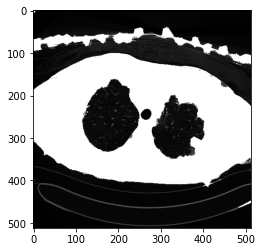

In [109]:
input_img="../data/l6.jpg" #Input image datapath
mask_im="../data/m6.jpg" #Mask image datapath
#Read image
I = cv2.imread(input_img)
I_copy = np.copy(I)
height, width, channel = I.shape #Size of image
#Interactive marking of image
cv2.namedWindow("Mark object/background", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Mark object/background", 900, 900)
cv2.setMouseCallback("Mark object/background", markSeeds)
while(True):
    cv2.imshow("Mark object/background", I_copy)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('o'):
        mode = "ob"
    elif k == ord('b'):
        mode = "bg"
    elif k == 27:
        break
cv2.destroyAllWindows()
#Convert image to CLELab colorspace
CLELabImg = cv2.cvtColor(I, cv2.COLOR_BGR2Lab)
#Generate superpixels using SLIC algorithm
SP = SPGObj.SuperPixelSLICgen(I, regionSize)

superPixelLabels = SP.getLabels() #Pixel labels defining which superpixel they belong to
list_SP = [None for i in range(SP.getNumberOfSuperpixels())] #List of SuperPixels

#Assign pixels to their respective SuperPixels
for i in range(height): 
    for j in range(width):
        if not list_SP[superPixelLabels[i][j]]:
            tempSP = SuperPixelNode()
            tempSP.label = superPixelLabels[i][j]
            tempSP.pixels.append((i,j))
            list_SP[superPixelLabels[i][j]] = tempSP
        else:
            list_SP[superPixelLabels[i][j]].pixels.append((i,j))

#For each superpixel node, calculate its CIELab histogram, mean of CIELab values, centroid & standardized CIELab values
for spNode in list_SP:
    num_pixels = len(spNode.pixels)
    i_total = 0
    j_total = 0
    Lab_total = [0,0,0]
    tempMask = np.zeros((height, width), np.uint8)
    for pixel in spNode.pixels:
        i,j = pixel
        i_total += i
        j_total += j
        Lab_total = [x + y for x,y in zip(Lab_total, CLELabImg[i][j])]
        tempMask[i][j] = 255
    spNode.CIELabHist = cv2.calcHist([CLELabImg], [0,1,2], tempMask, SPGObj.noOfBins, SPGObj.rangeOfL + SPGObj.rangeOfa + SPGObj.rangeOfb)
    spNode.centroid += (i_total // num_pixels, j_total // num_pixels)
    spNode.meanCIELab = [x / num_pixels for x in Lab_total]


#mark the object and background superpixels based on the interactive marking of the pixels
for pixels in objectPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "ob"
for pixel in backGroundPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "bg"

#Draw superpixel mask and centroids
I2 = SPGObj.drawSPMask(I, SP)
I2 = SPGObj.drawCentroids(I2, list_SP)

#make object and image masks
obj_mask=np.zeros((height,width), dtype=np.uint8)
for pixel in objectPixels:
    i,j=pixel
    obj_mask[i][j]=255
background_mask=np.zeros((height, width),dtype=np.uint8)
for pixel in backGroundPixels:
    i,j=pixel
    background_mask[i][j]=255

#calculate object and background histograms
object_hist=cv2.calcHist([CLELabImg],[0,1,2],obj_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)
background_hist=cv2.calcHist([CLELabImg],[0,1,2],background_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)

#generate graph
G=SPGObj.graph_gen(list_SP,object_hist,background_hist)
for node in G.nodes():
    if node.label=='s':
        s=node
    if node.label=='t':
        t=node
#get the residual graph
residual_graph=BK(G,s,t,capacity='sim').getResidual()
s_tree,t_tree=residual_graph.graph['trees']
partition=(set(s_tree),set(G)-set(s_tree)) #partition according to minCut after using BK algorithm
segmask=np.zeros((height,width),dtype=np.uint8) #segmentation mask of background (according to partition)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmask[i][j]=1
segmented_img=cv2.bitwise_and(I,I,mask=segmask) #segmented image
for superpixels in partition[1]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmented_img[i][j][0]=255
        segmented_img[i][j][1]=255
        segmented_img[i][j][2]=255
my_mask=np.zeros(np.shape(segmented_img)[0:2], dtype=float)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        my_mask[i][j]=1
for superpixels in partition[1]:
    for pixels in superpixels.pixels:
        i,j=pixels
        my_mask[i][j]=0
plt.imshow(segmented_img[...,::-1]) #plot image

0.8767830373838997


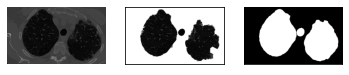

In [110]:
mask_im1= cv2.imread(mask_im)
og_im=cv2.imread(input_img)
x1,x2,y1,y2=150,360,60,420
gray_image = cv2.cvtColor(mask_im1, cv2.COLOR_BGR2GRAY)
ot=np.logical_or(np.zeros(np.shape(mask_im1)[:2], dtype=float),(gray_image.astype(float))/255)
intersection = np.logical_and(ot[x1:x2,y1:y2,], my_mask[x1:x2,y1:y2,])
print(2. * intersection.sum() / (my_mask[x1:x2,y1:y2,].sum() + ot[x1:x2,y1:y2,].sum()))
(thresh, fin_mask) = cv2.threshold(gray_image, 10, 255, cv2.THRESH_BINARY)
fig,ax=plt.subplots(1,3, figsize=(6,3))
ax[0].axis("off")
ax[0].imshow(og_im[x1:x2,y1:y2,])
ax[1].imshow(segmented_img[x1:x2,y1:y2,]) #plot image
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].imshow(fin_mask[x1:x2,y1:y2,], cmap='gray')
plt.savefig("../results/r6_2.jpeg",dpi=800);

In [93]:
#Read image
I = cv2.imread(input_img)
I_copy = np.copy(I)
height, width, channel = I.shape #Size of image

In [94]:
#Interactive marking of image
cv2.namedWindow("Mark object/background", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Mark object/background", 900, 900)
cv2.setMouseCallback("Mark object/background", markSeeds)
while(True):
    cv2.imshow("Mark object/background", I_copy)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('o'):
        mode = "ob"
    elif k == ord('b'):
        mode = "bg"
    elif k == 27:
        break
cv2.destroyAllWindows()

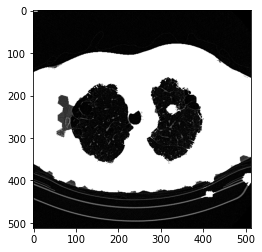

In [95]:
#Convert image to CLELab colorspace
CLELabImg = cv2.cvtColor(I, cv2.COLOR_BGR2Lab)
#Generate superpixels using SLIC algorithm
SP = SPGObj.SuperPixelSLICgen(I, regionSize)

superPixelLabels = SP.getLabels() #Pixel labels defining which superpixel they belong to
list_SP = [None for i in range(SP.getNumberOfSuperpixels())] #List of SuperPixels

#Assign pixels to their respective SuperPixels
for i in range(height): 
    for j in range(width):
        if not list_SP[superPixelLabels[i][j]]:
            tempSP = SuperPixelNode()
            tempSP.label = superPixelLabels[i][j]
            tempSP.pixels.append((i,j))
            list_SP[superPixelLabels[i][j]] = tempSP
        else:
            list_SP[superPixelLabels[i][j]].pixels.append((i,j))

#For each superpixel node, calculate its CIELab histogram, mean of CIELab values, centroid & standardized CIELab values
for spNode in list_SP:
    num_pixels = len(spNode.pixels)
    i_total = 0
    j_total = 0
    Lab_total = [0,0,0]
    tempMask = np.zeros((height, width), np.uint8)
    for pixel in spNode.pixels:
        i,j = pixel
        i_total += i
        j_total += j
        Lab_total = [x + y for x,y in zip(Lab_total, CLELabImg[i][j])]
        tempMask[i][j] = 255
    spNode.CIELabHist = cv2.calcHist([CLELabImg], [0,1,2], tempMask, SPGObj.noOfBins, SPGObj.rangeOfL + SPGObj.rangeOfa + SPGObj.rangeOfb)
    spNode.centroid += (i_total // num_pixels, j_total // num_pixels)
    spNode.meanCIELab = [x / num_pixels for x in Lab_total]


#mark the object and background superpixels based on the interactive marking of the pixels
for pixels in objectPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "ob"
for pixel in backGroundPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "bg"

#Draw superpixel mask and centroids
I2 = SPGObj.drawSPMask(I, SP)
I2 = SPGObj.drawCentroids(I2, list_SP)

#make object and image masks
obj_mask=np.zeros((height,width), dtype=np.uint8)
for pixel in objectPixels:
    i,j=pixel
    obj_mask[i][j]=255
background_mask=np.zeros((height, width),dtype=np.uint8)
for pixel in backGroundPixels:
    i,j=pixel
    background_mask[i][j]=255

#calculate object and background histograms
object_hist=cv2.calcHist([CLELabImg],[0,1,2],obj_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)
background_hist=cv2.calcHist([CLELabImg],[0,1,2],background_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)

#generate graph
G=SPGObj.graph_gen(list_SP,object_hist,background_hist)
for node in G.nodes():
    if node.label=='s':
        s=node
    if node.label=='t':
        t=node
#get the residual graph
residual_graph=BK(G,s,t,capacity='sim').getResidual()
s_tree,t_tree=residual_graph.graph['trees']
partition=(set(s_tree),set(G)-set(s_tree)) #partition according to minCut after using BK algorithm
segmask=np.zeros((height,width),dtype=np.uint8) #segmentation mask of background (according to partition)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmask[i][j]=1
segmented_img=cv2.bitwise_and(I,I,mask=segmask) #segmented image
for superpixels in partition[1]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmented_img[i][j][0]=255
        segmented_img[i][j][1]=255
        segmented_img[i][j][2]=255
my_mask=np.zeros(np.shape(segmented_img)[0:2], dtype=float)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        my_mask[i][j]=1
for superpixels in partition[1]:
    for pixels in superpixels.pixels:
        i,j=pixels
        my_mask[i][j]=0
plt.imshow(segmented_img[...,::-1]) #plot image
figname="../results/seg_1.jpeg"
# plt.savefig(figname,dpi=800)
# plt.close()


0.8788679607918508


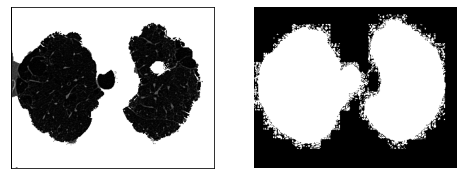

In [96]:
mask_im1= cv2.imread(mask_im)
og_im=cv2.imread(input_img)
x1,x2,y1,y2=130,400,80,420
gray_image = cv2.cvtColor(mask_im1, cv2.COLOR_BGR2GRAY)
ot=np.logical_or(np.zeros(np.shape(mask_im1)[:2]),(gray_image.astype(float))/255)
intersection = np.logical_and(ot[x1:x2,y1:y2,], my_mask[x1:x2,y1:y2,])
print(2. * intersection.sum() / (my_mask[x1:x2,y1:y2,].sum() + ot[x1:x2,y1:y2,].sum()))
fig,ax=plt.subplots(1,3, figsize=(8,8))
ax[0].axis("off")
ax[0].imshow(og_im[x1:x2,y1:y2,])
ax[1].spines["left"].set_color('black')
ax[1].spines["left"].set_linewidth(1)
ax[1].imshow(segmented_img[x1:x2,y1:y2,]) #plot image
ax[1].set_xticks([])
ax[1].set_yticks([])
# ax[0].axis('off')
ax[2].axis("off")
ax[2].imshow(ot[x1:x2,y1:y2,], cmap='gray')
plt.savefig("../results");

Same approach but using RGB colorspace instead of CIELab colorspace to compare which is better

In [130]:
input_img = "../data/deer.png"
regionSize = 20

objectPixels = []
mode = "ob"
backGroundPixels = []
drawing = False
I = None
I_copy = None

def markSeeds (event, x, y, flags, param):
    global drawing, mode, backGroundPixels, objectPixels, I_copy
    h,w,_ = I_copy.shape
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == "ob":
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    objectPixels.append((y, x))
                cv2.line(I_copy,(x-3,y),(x+3,y),(0,0,225))
            else:
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    backGroundPixels.append((y, x))
                cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        if mode == "ob":
            cv2.line(I_copy, (x-3, y), (x+3, y), (0,0,225))
        else:
            cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))

I = cv2.imread(input_img)
I_copy = np.copy(I)
height, width, channel = I.shape

cv2.namedWindow("Mark object/background", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Mark object/background", 900, 900)
cv2.setMouseCallback("Mark object/background", markSeeds)
while(True):
    cv2.imshow("Mark object/background", I_copy)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('o'):
        mode = "ob"
    elif k == ord('b'):
        mode = "bg"
    elif k == 27:
        break
cv2.destroyAllWindows()
SPGObj = SuperPixelGraph()
# CLELabImg = cv2.cvtColor(I, cv2.COLOR_BGR2Lab)
CLELabImg= I

SP = SPGObj.SuperPixelSLICgen(I, regionSize)
superPixelLabels = SP.getLabels()
list_SP = [None for i in range(SP.getNumberOfSuperpixels())]

for i in range(height):
    for j in range(width):
        if not list_SP[superPixelLabels[i][j]]:
            tempSP = SuperPixelNode()
            tempSP.label = superPixelLabels[i][j]
            tempSP.pixels.append((i,j))
            list_SP[superPixelLabels[i][j]] = tempSP
        else:
            list_SP[superPixelLabels[i][j]].pixels.append((i,j))


for spNode in list_SP:
    num_pixels = len(spNode.pixels)
    i_total = 0
    j_total = 0
    Lab_total = [0,0,0]
    tempMask = np.zeros((height, width), np.uint8)
    for pixel in spNode.pixels:
        i,j = pixel
        i_total += i
        j_total += j
        Lab_total = [x + y for x,y in zip(Lab_total, CLELabImg[i][j])]
        tempMask[i][j] = 255
    spNode.CIELabHist = cv2.calcHist([CLELabImg], [0,1,2], tempMask, SPGObj.noOfBins, SPGObj.rangeOfL + SPGObj.rangeOfa + SPGObj.rangeOfb)
    spNode.centroid += (i_total // num_pixels, j_total // num_pixels)
    spNode.meanCIELab = [x / num_pixels for x in Lab_total]
    
for pixels in objectPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "ob"
for pixel in backGroundPixels:
    i, j = pixels
    list_SP[superPixelLabels[i][j]].type = "bg"

I2 = SPGObj.drawSPMask(I, SP)
I2 = SPGObj.drawCentroids(I2, list_SP)

obj_mask=np.zeros((height,width), dtype=np.uint8)
for pixel in objectPixels:
    i,j=pixel
    obj_mask[i][j]=255
background_mask=np.zeros((height, width),dtype=np.uint8)
for pixel in backGroundPixels:
    i,j=pixel
    background_mask[i][j]=255

object_hist=cv2.calcHist([CLELabImg],[0,1,2],obj_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)
background_hist=cv2.calcHist([CLELabImg],[0,1,2],background_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)

G=SPGObj.graph_gen(list_SP,object_hist,background_hist)
for node in G.nodes():
    if node.label=='s':
        s=node
    if node.label=='t':
        t=node
residual_graph=BK(G,s,t,capacity='sim').getResidual()
s_tree,t_tree=residual_graph.graph['trees']
partition=(set(s_tree),set(G)-set(s_tree))
segmask=np.zeros((height,width),dtype=np.uint8)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmask[i][j]=1
segmented_img=cv2.bitwise_and(I,I,mask=segmask)

CIELabSP = np.zeros(I.shape,dtype = np.uint8)
for sp in list_SP:
    for pixels in sp.pixels:
        i,j = pixels
        CIELabSP[i][j] = sp.meanCIELab
CIELabSP = cv2.cvtColor(CIELabSP, cv2.COLOR_Lab2RGB)
plt.imshow(segmented_img[...,::-1])
plt.axis('off')
name_img="../results/seg_2.jpeg"
# plt.savefig(name_img,dpi=800)
plt.close()

Comparing accuracy with mask

In [115]:
mask_img=cv2.imread("../data/deer_mask.png")
mask_img=np.asarray(mask_img)
accuracy_mat = np.logical_xor(segmented_img, mask_img) 
	 
accuracy = np.sum(accuracy_mat)
print("Accuracy: ", 100 - accuracy/(height*width), "%")


Accuracy:  99.94015873015873 %


Same approach but without using superpixels to measure the time difference </br>
Below cell execution takes a lot of time as the graph algorithm is O(mn^2|C|), and we had defined average superpixel region size as 20 pixels, so if superpixels aren't used, n increases approximately 20 times. This causes the time to increase approximately 20^3 times (assuming m would be >= n/2 as each vertex has atleast 1 edge). Initially, with superpixels it takes around 20-60 secs to segment a single image (depending on the size and number of pixels in an image). 8000 times increase in time would require segmentation time around 8000 minutes. We ran the code for 15 mins and interrupted it. So, run the below cell keeping this in consideration. 

In [ ]:
input_img = "../data/med.png"
regionSize = 20

objectPixels = []
mode = "ob"
backGroundPixels = []
drawing = False
I = None
I_copy = None

def markSeeds (event, x, y, flags, param):
    global drawing, mode, backGroundPixels, objectPixels, I_copy
    h,w,_ = I_copy.shape
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            if mode == "ob":
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    objectPixels.append((y, x))
                cv2.line(I_copy,(x-3,y),(x+3,y),(0,0,225))
            else:
                if (x>=0 and x<=w-1) and (y>=0 and y<=h-1):
                    backGroundPixels.append((y, x))
                cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        if mode == "ob":
            cv2.line(I_copy, (x-3, y), (x+3, y), (0,0,225))
        else:
            cv2.line(I_copy, (x-3, y), (x+3, y), (255,0,0))

I = cv2.imread(input_img)
I_copy = np.copy(I)
height, width, channel = I.shape

cv2.namedWindow("Mark object/background", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Mark object/background", 900, 900)
cv2.setMouseCallback("Mark object/background", markSeeds)
while(True):
    cv2.imshow("Mark object/background", I_copy)
    k = cv2.waitKey(1) & 0xFF
    if k == ord('o'):
        mode = "ob"
    elif k == ord('b'):
        mode = "bg"
    elif k == 27:
        break
cv2.destroyAllWindows()
SPGObj = SuperPixelGraph()
start_time=time.time()
CLELabImg = cv2.cvtColor(I, cv2.COLOR_BGR2Lab)
# CLELabImg= I

# SP = SPGObj.SuperPixelSLICgen(I, regionSize)
# superPixelLabels = SP.getLabels()
# list_SP = [None for i in range(SP.getNumberOfSuperpixels())]

# for i in range(height):
#     for j in range(width):
#         if not list_SP[superPixelLabels[i][j]]:
#             tempSP = SuperPixelNode()
#             tempSP.label = superPixelLabels[i][j]
#             tempSP.pixels.append((i,j))
#             list_SP[superPixelLabels[i][j]] = tempSP
#         else:
#             list_SP[superPixelLabels[i][j]].pixels.append((i,j))

list_SP=[None for i in range(height*width)]

for i in range(height):
    for j in range(width):
        tempSP = SuperPixelNode()
        tempSP.label = i*width+j
        tempSP.pixels.append((i,j))
        list_SP[i*width+j] = tempSP

for spNode in list_SP:
    num_pixels = len(spNode.pixels)
    i_total = 0
    j_total = 0
    Lab_total = [0,0,0]
    tempMask = np.zeros((height, width), np.uint8)
    for pixel in spNode.pixels:
        i,j = pixel
        i_total += i
        j_total += j
        Lab_total = [x + y for x,y in zip(Lab_total, CLELabImg[i][j])]
        tempMask[i][j] = 255
    spNode.CIELabHist = cv2.calcHist([CLELabImg], [0,1,2], tempMask, SPGObj.noOfBins, SPGObj.rangeOfL + SPGObj.rangeOfa + SPGObj.rangeOfb)
    spNode.centroid += (i_total // num_pixels, j_total // num_pixels)
    spNode.meanCIELab = [x / num_pixels for x in Lab_total]
    
for pixels in objectPixels:
    i, j = pixels
    list_SP[i*width+j].type = "ob"
for pixel in backGroundPixels:
    i, j = pixels
    list_SP[i*width+j].type = "bg"

obj_mask=np.zeros((height,width), dtype=np.uint8)
for pixel in objectPixels:
    i,j=pixel
    obj_mask[i][j]=255
background_mask=np.zeros((height, width),dtype=np.uint8)
for pixel in backGroundPixels:
    i,j=pixel
    background_mask[i][j]=255

object_hist=cv2.calcHist([CLELabImg],[0,1,2],obj_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)
background_hist=cv2.calcHist([CLELabImg],[0,1,2],background_mask,SPGObj.noOfBins, SPGObj.rangeOfL+SPGObj.rangeOfa+SPGObj.rangeOfb)

G=SPGObj.graph_gen(list_SP,object_hist,background_hist)
for node in G.nodes():
    if node.label=='s':
        s=node
    if node.label=='t':
        t=node

residual_graph=BK(G,s,t,capacity='sim').getResidual()

s_tree,t_tree=residual_graph.graph['trees']
partition=(set(s_tree),set(G)-set(s_tree))
segmask=np.zeros((height,width),dtype=np.uint8)
for superpixels in partition[0]:
    for pixels in superpixels.pixels:
        i,j=pixels
        segmask[i][j]=1
segmented_img=cv2.bitwise_and(I,I,mask=segmask)
# for superpixels in partition[1]:
#     for pixels in superpixels.pixels:
#         i,j=pixels
#         segmented_img[i][j][0]=255
#         segmented_img[i][j][1]=255
#         segmented_img[i][j][2]=255
end_time=time.time()
time_elapse=end_time-start_time
print(time_elapse)
CIELabSP = np.zeros(I.shape,dtype = np.uint8)
for sp in list_SP:
    for pixels in sp.pixels:
        i,j = pixels
        CIELabSP[i][j] = sp.meanCIELab
CIELabSP = cv2.cvtColor(CIELabSP, cv2.COLOR_Lab2RGB)

plt.imshow(segmented_img[...,::-1])
plt.axis('off')
plt.close()